# Лекция 3
## Модели ARIMA и GARCH

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -32.777989
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


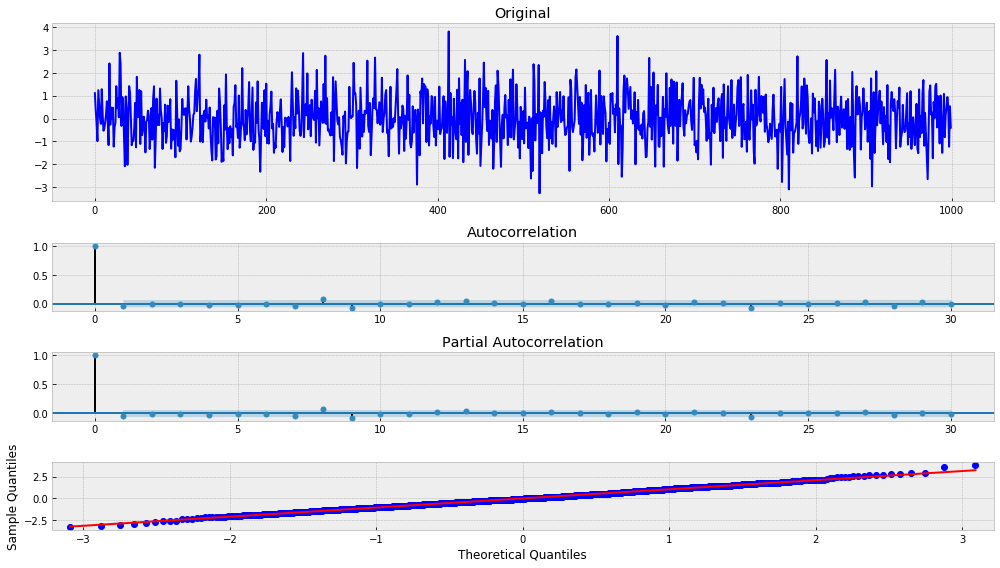

In [5]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

Results of Dickey-Fuller Test:
Test Statistic                  -1.905402
p-value                          0.329524
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


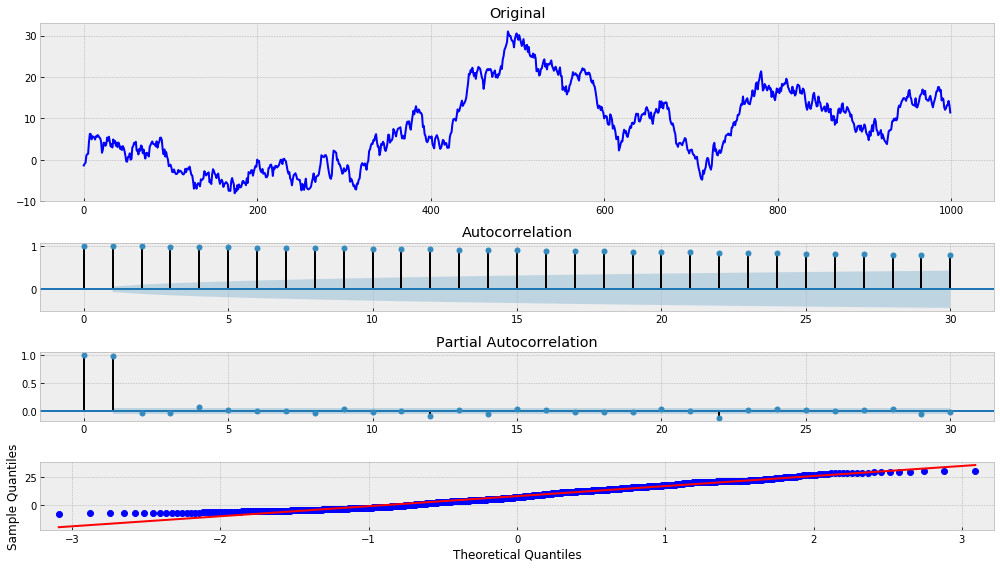

In [11]:
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -2.503717
p-value                          0.114573
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


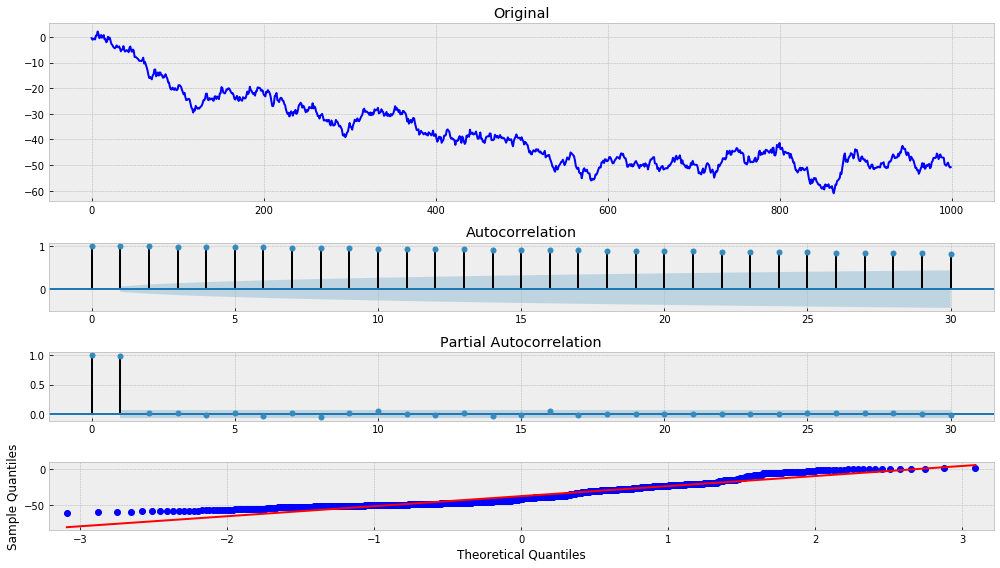

In [10]:
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -1.871646e+01
p-value                        2.033589e-30
#Lags Used                     2.000000e+00
Number of Observations Used    9.960000e+02
Critical Value (1%)           -3.436933e+00
Critical Value (5%)           -2.864446e+00
Critical Value (10%)          -2.568317e+00
dtype: float64


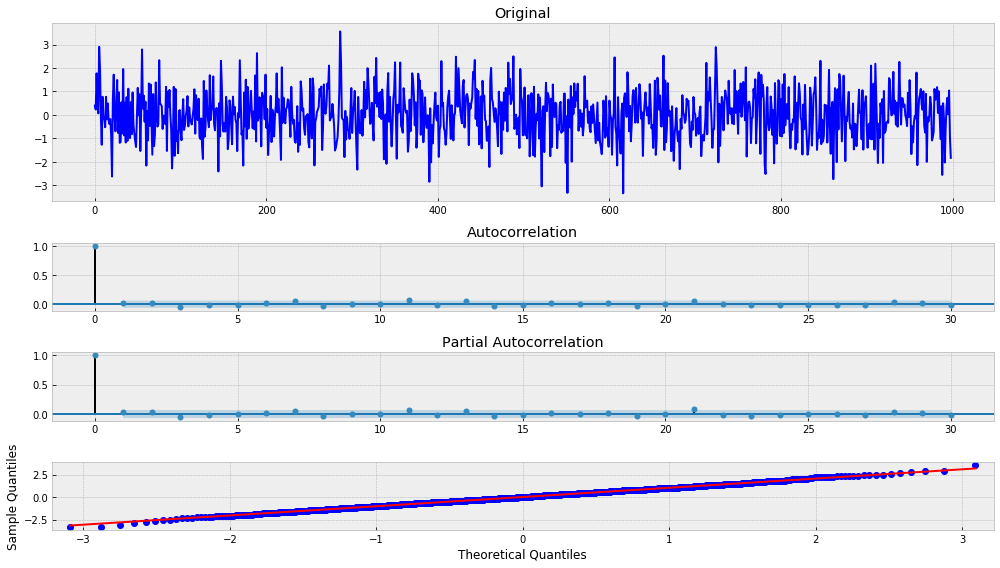

In [12]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


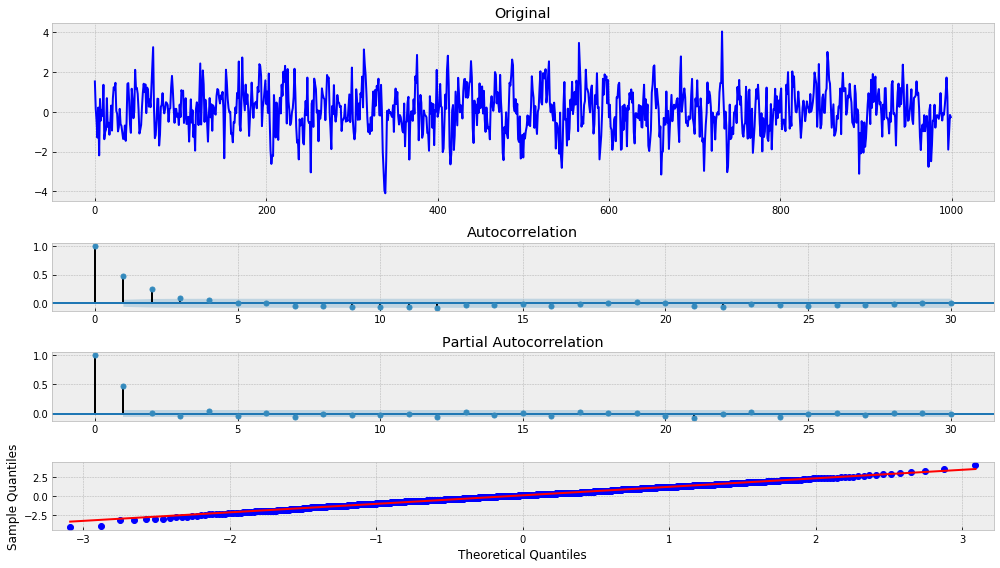

In [13]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [14]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


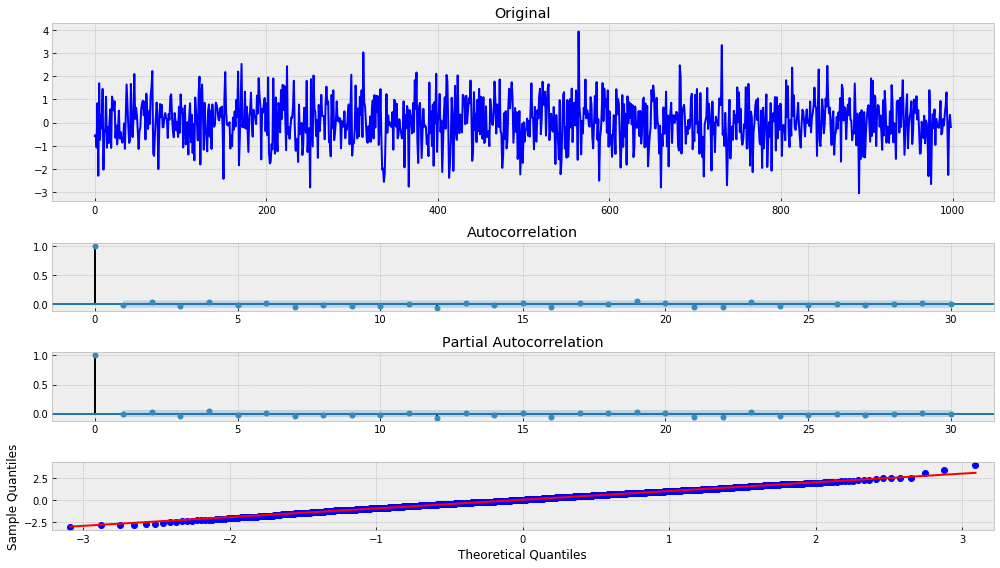

In [15]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


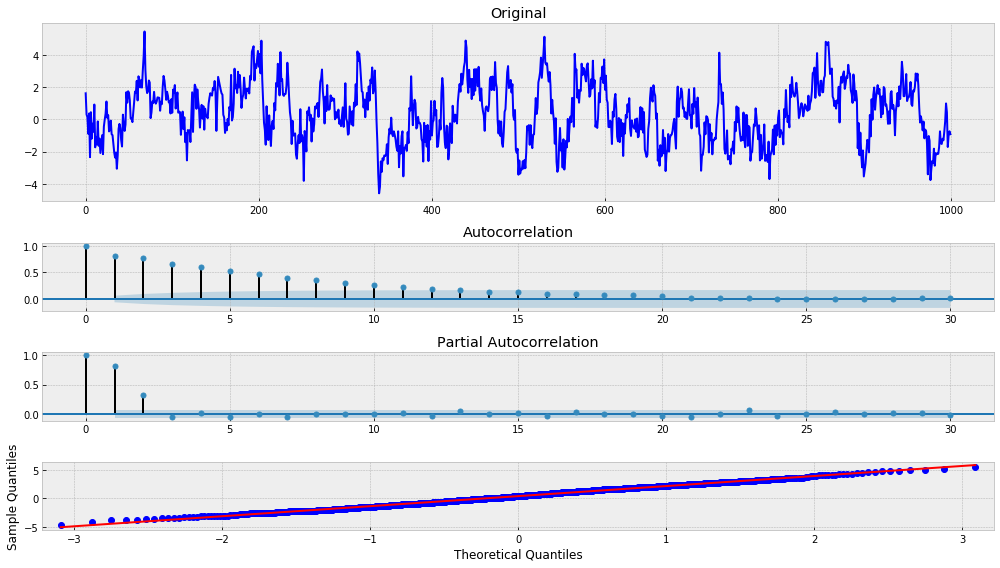

In [36]:
np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [37]:
mdl = smt.AR(x).fit(maxlag=3, trend='nc')

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


Results of Dickey-Fuller Test:
Test Statistic                 -31.609276
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


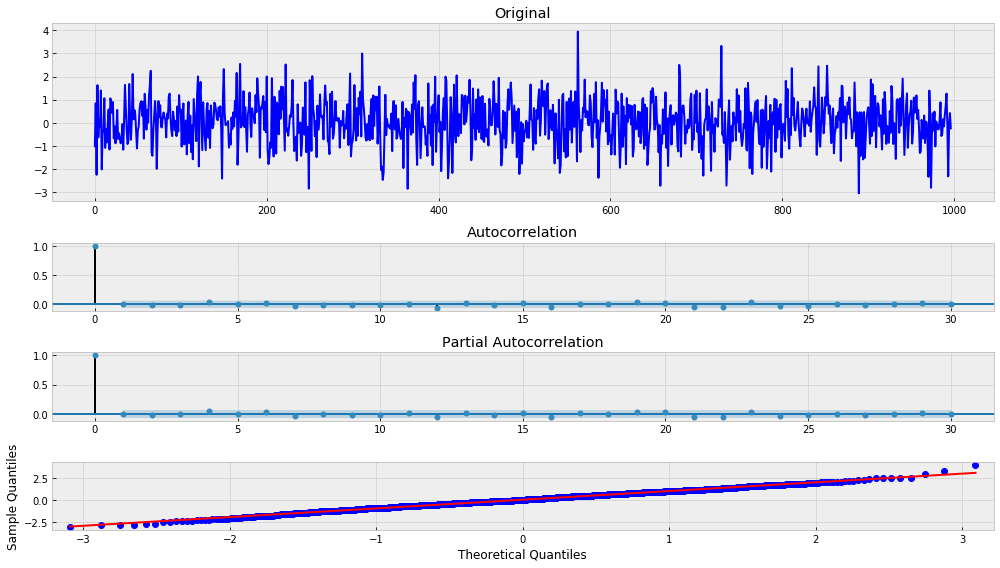

In [38]:
tsplot(mdl.resid, lags=30)

In [39]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


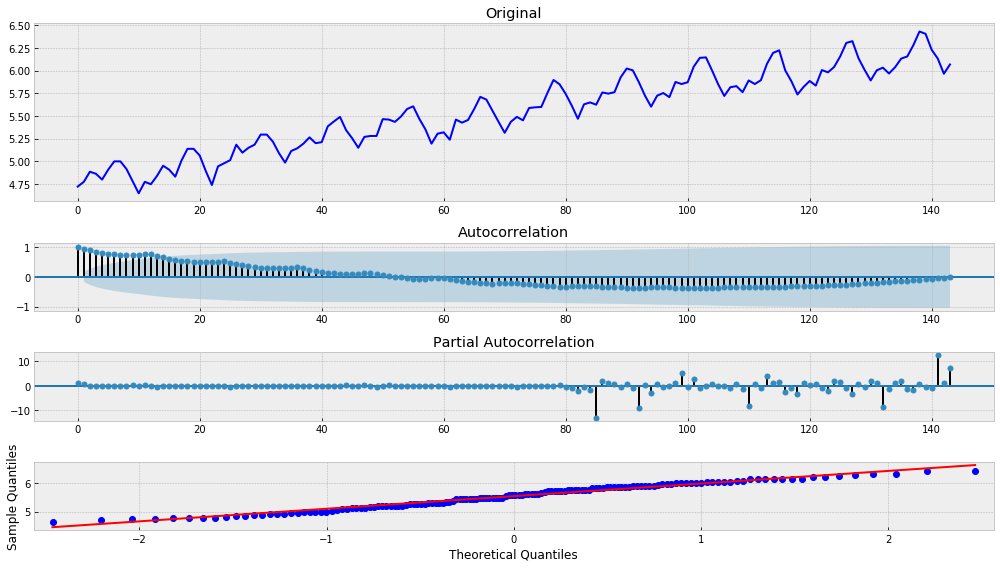

In [40]:
tsplot(series)

In [41]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[ 0.57771154  0.22901853  0.06195854 -0.08919923  0.24920719 -0.15657936
  0.04266833 -0.01690364  0.24480034 -0.29458944  0.03968739  0.48535593
 -0.13295218 -0.31857377  0.17769943 -0.12830694 -0.00824594 -0.12456788
  0.17055048 -0.20087872  0.00313821  0.07960796  0.21843347  0.19825546
 -0.12661933 -0.17744898]


Results of Dickey-Fuller Test:
Test Statistic                -1.077826e+01
p-value                        2.290070e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


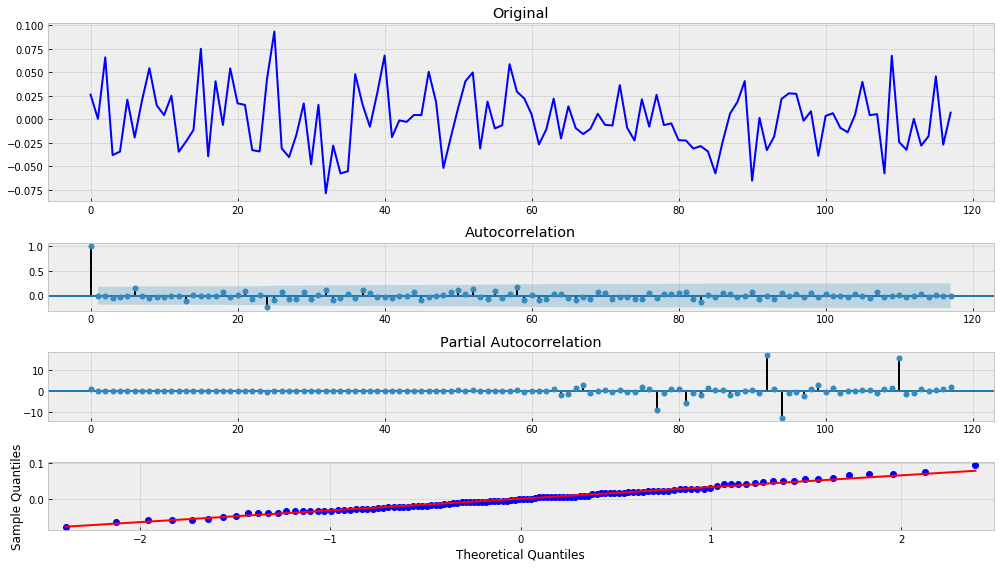

In [22]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


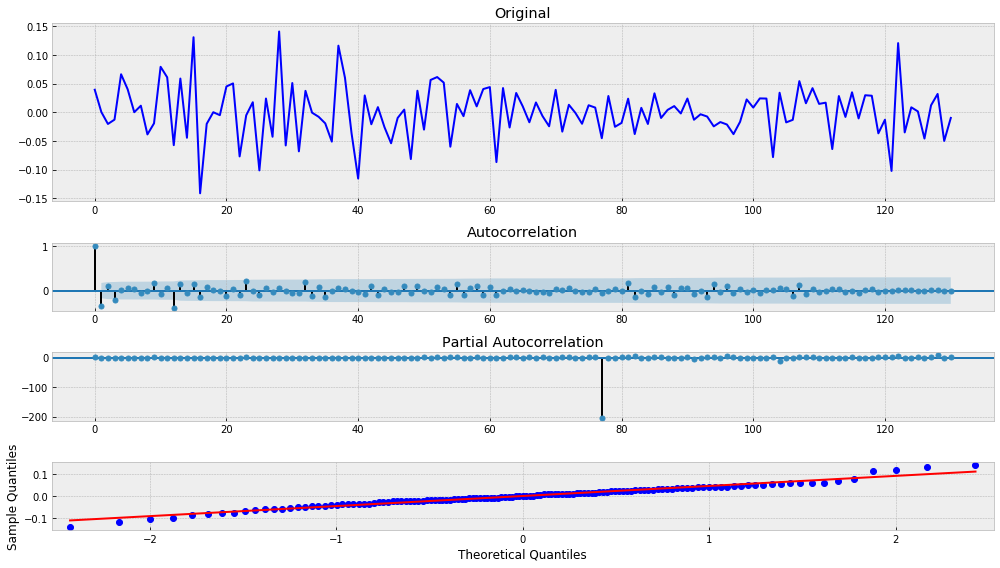

In [42]:
series_diffed = np.diff(series)
series_diffed = series_diffed[12:] - series_diffed[:-12]
tsplot(series_diffed)

In [43]:
mdl_diffed = smt.AR(series_diffed).fit(maxlag=30, ic='aic', trend='nc')
print(mdl_diffed.params)

[-0.44356319 -0.04674482 -0.13346706 -0.11109479  0.03302162  0.03112745
 -0.06515299  0.03505331  0.16104996 -0.00834682 -0.11144103 -0.42633578
 -0.13933338]


Results of Dickey-Fuller Test:
Test Statistic                -1.084592e+01
p-value                        1.572554e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


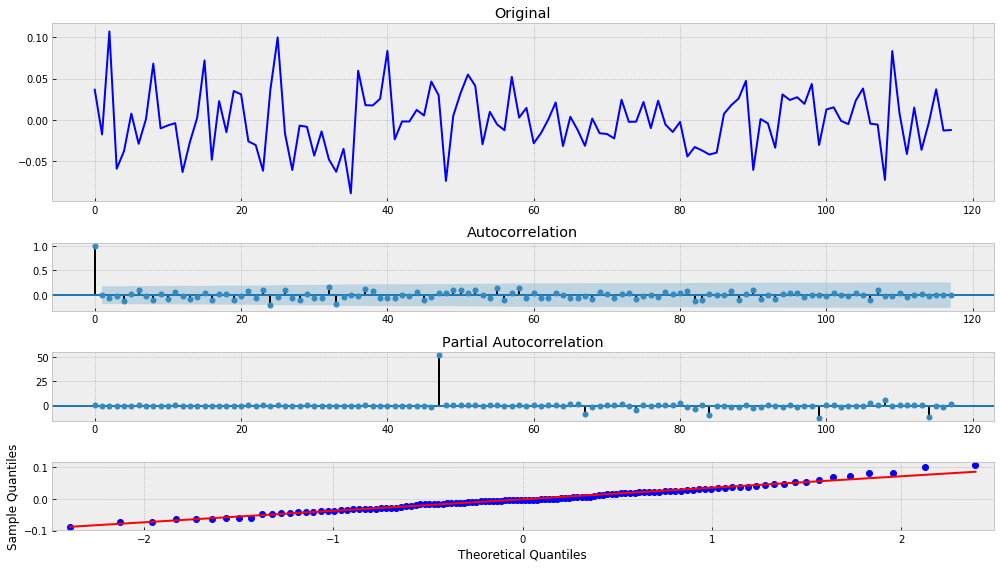

In [44]:
tsplot(mdl_diffed.resid)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7105.938
Method:                           mle   S.D. of innovations              1.002
Date:                Sun, 26 May 2019   AIC                          14221.876
Time:                        23:12:46   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                                                                              
              

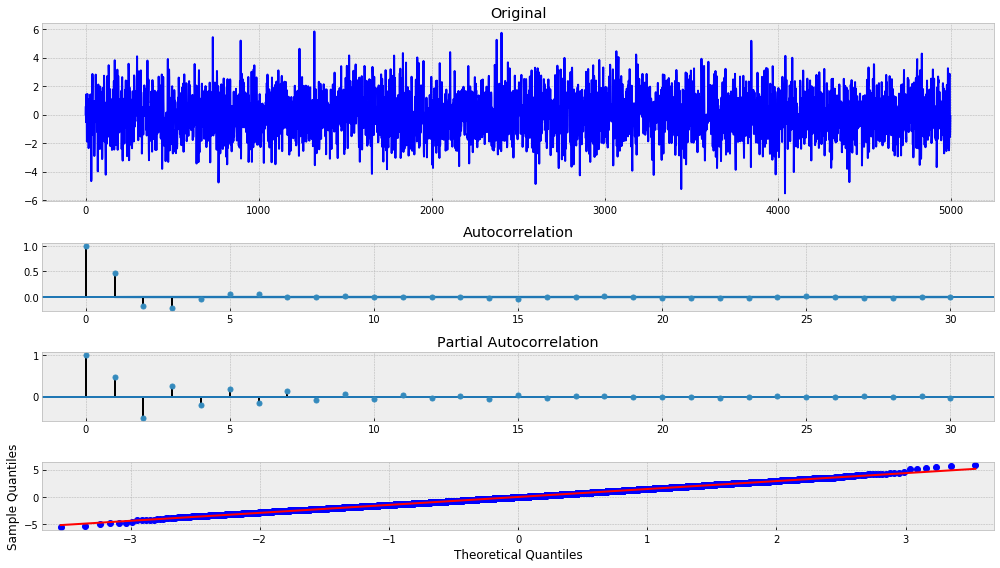

In [46]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

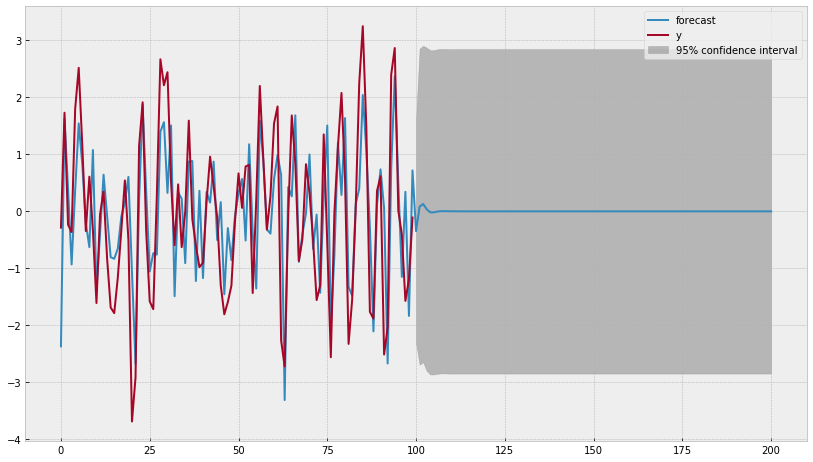

In [26]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(start=4900, end=5100, ax=ax)

In [27]:
mdl.aic

14221.876194276512

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [28]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 14516.60147 | order: (0, 1)
aic: 16695.16237 | order: (1, 0)
aic: 14470.93086 | order: (1, 1)
aic: 14249.80329 | order: (1, 3)
aic: 14238.01885 | order: (1, 4)
aic: 15220.00838 | order: (2, 0)
aic: 14244.17036 | order: (2, 1)
aic: 14221.87619 | order: (2, 2)
aic: 14221.79239 | order: (2, 3)
aic: 14222.40901 | order: (2, 4)
aic: 14876.89571 | order: (3, 0)
aic: 14221.82897 | order: (3, 1)
aic: 14222.67869 | order: (3, 2)
aic: 14221.50753 | order: (3, 3)
aic: 14223.50596 | order: (3, 4)
aic: 14676.45381 | order: (4, 0)
aic: 14221.86156 | order: (4, 1)
aic: 14222.41410 | order: (4, 2)
aic: 14222.13779 | order: (4, 3)
aic: 14225.24684 | order: (4, 4)
aic: 14221.50753 | order: (3, 3)


Применим модель ARMA к нашей TS

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


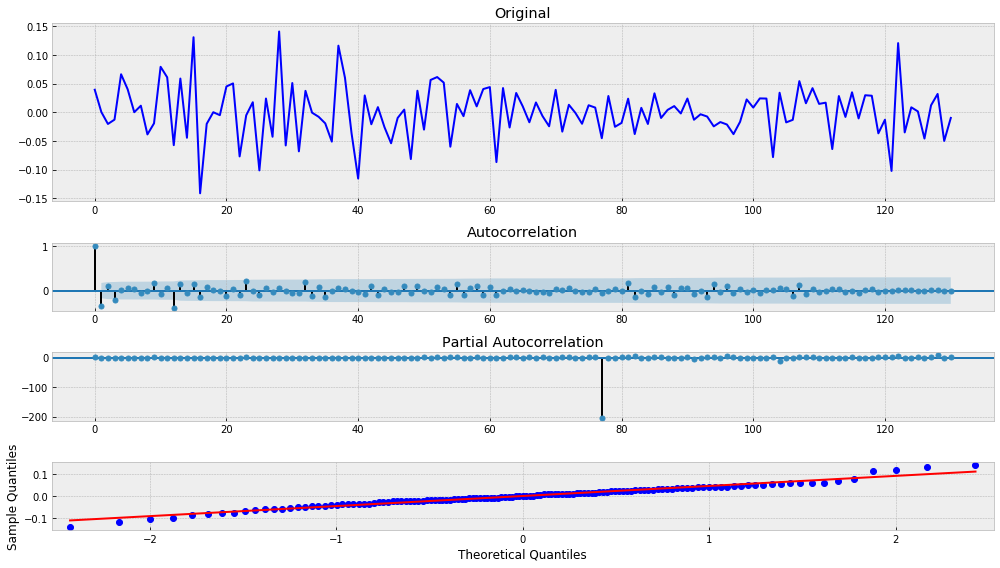

In [47]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [48]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -461.63882 | order: (4, 4)


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Results of Dickey-Fuller Test:
Test Statistic                  -4.343317
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


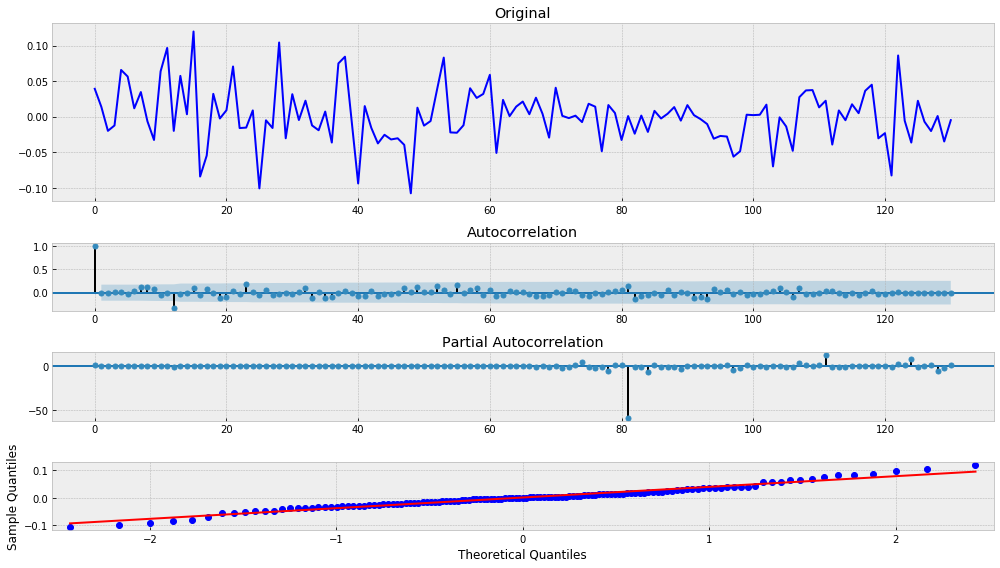

In [30]:
mdl = smt.ARMA(series, order=(4, 4)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

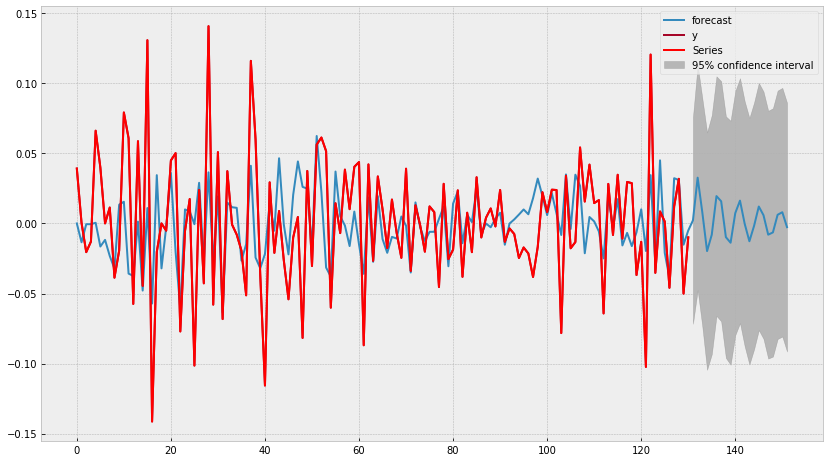

In [31]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_pa

aic: -461.63882 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.343317
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


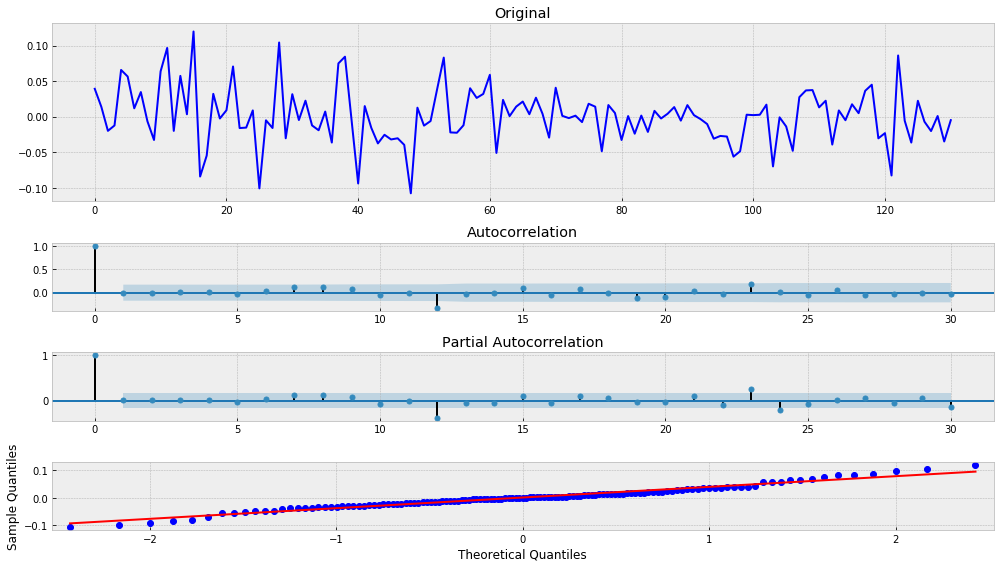

In [55]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

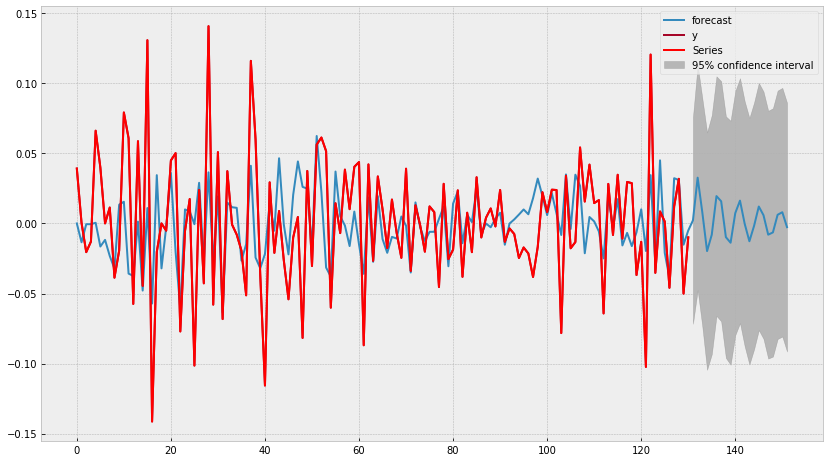

In [56]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


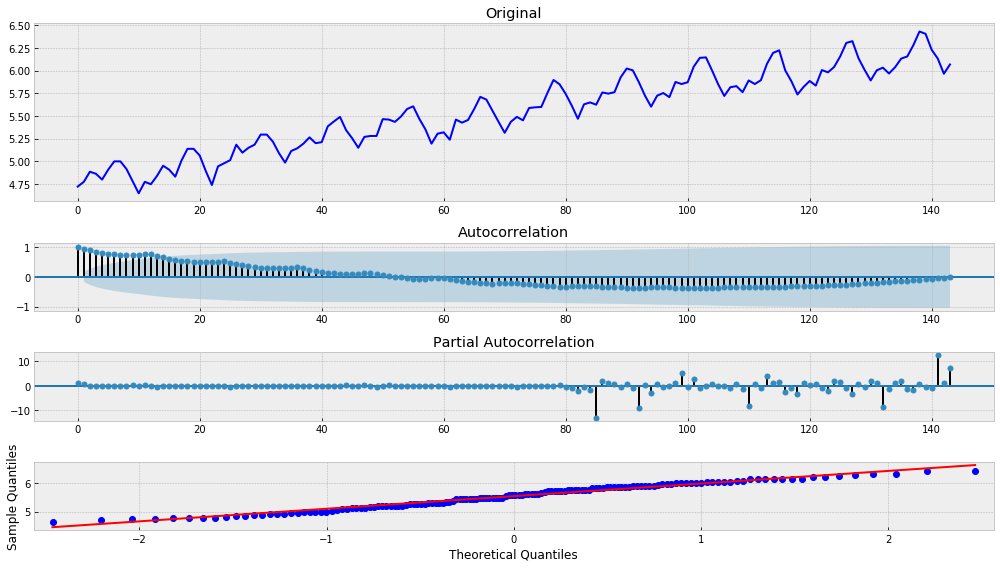

In [34]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
tsplot(series)

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -294.55915 | order: (4, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -2.256176
p-value                          0.186492
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


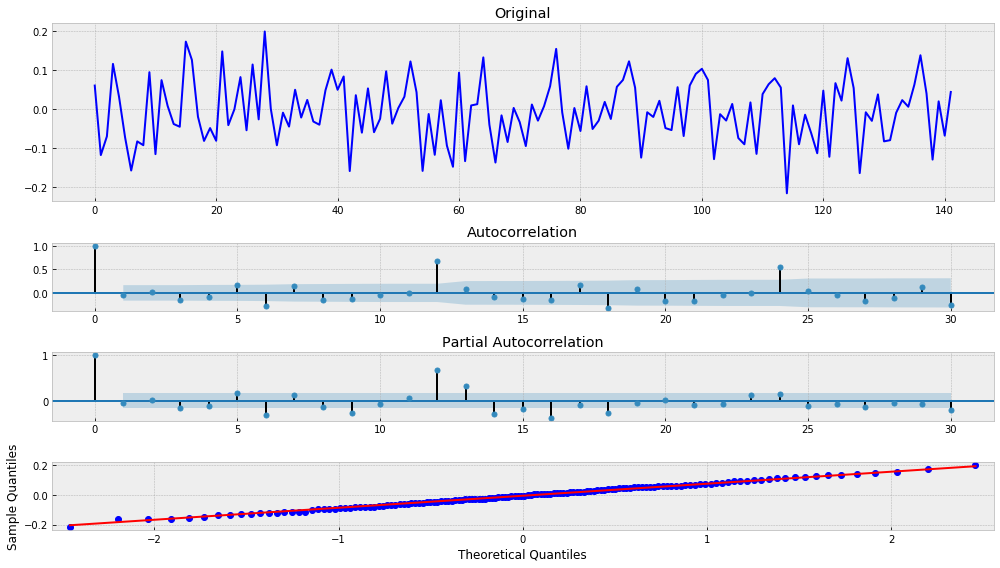

In [35]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


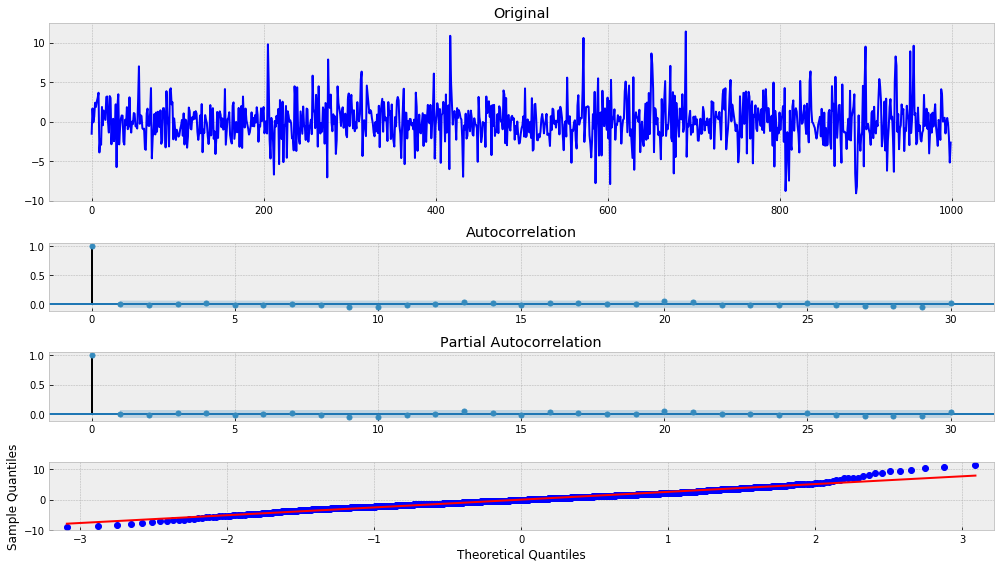

In [50]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [53]:
!pip install arch --install-option="--no-binary"

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/pip/_internal/commands/install.py:211: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
    100% |████████████████████████████████| 788kB 4.3MB/s ta 0:00:011
Skipping bdist_wheel for arch, due to binaries being disabled for it.
  Running setup.py install for arch ... done
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


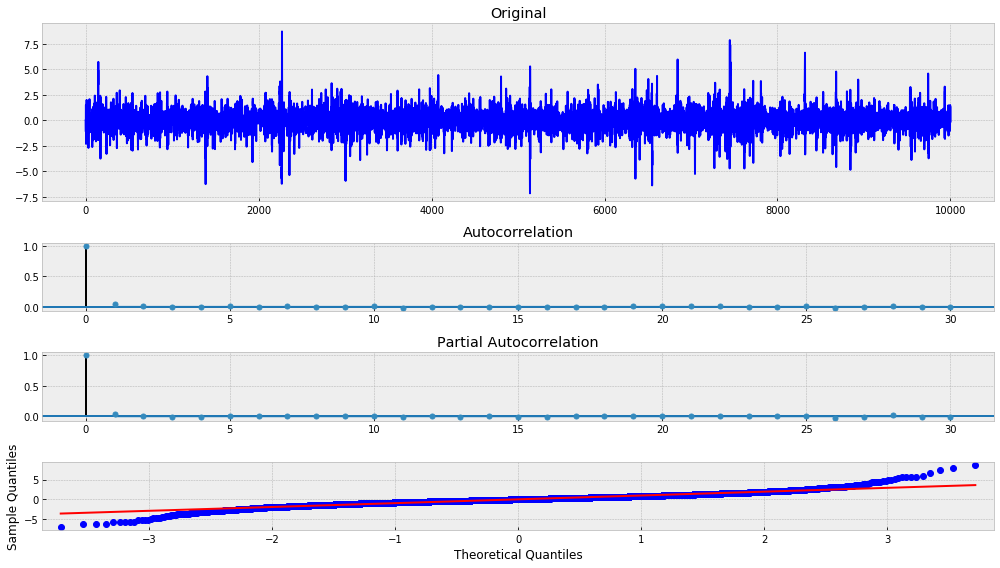

In [20]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [21]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sat, May 18 2019   Df Residuals:                     9996
Time:       

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [148]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

aic: -461.63243 | order: (4, 0, 4)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Results of Dickey-Fuller Test:
Test Statistic                  -4.343276
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


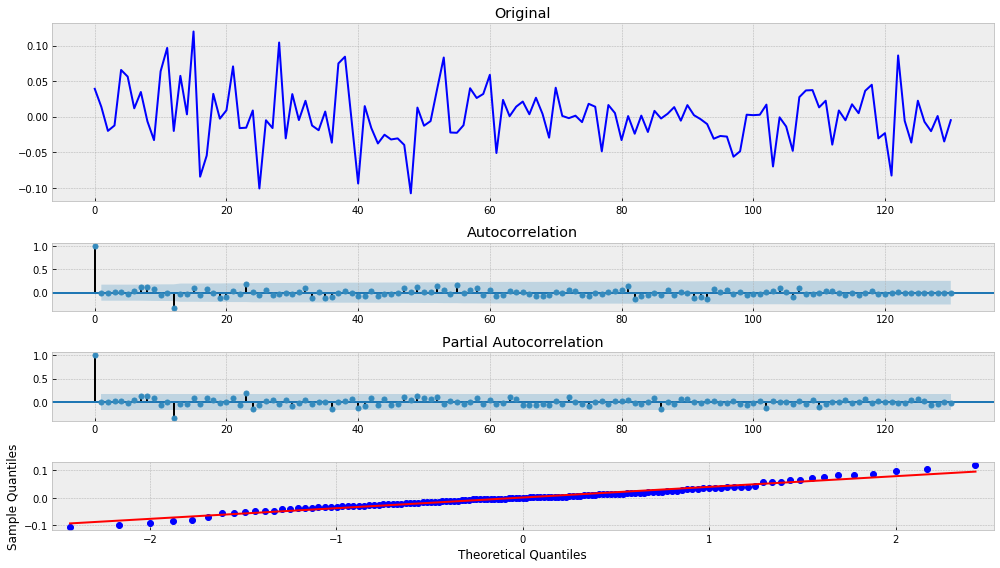

In [153]:
tsplot(mdl.resid)

Применим GARCH

In [150]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                229.094
Distribution:      Standardized Student's t   AIC:                          -436.188
Method:                  Maximum Likelihood   BIC:                          -404.561
                                              No. Observations:                  131
Date:                      Tue, Jul 24 2018   Df Residuals:                      120
Time:                              13:34:48   Df Model:                           11
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


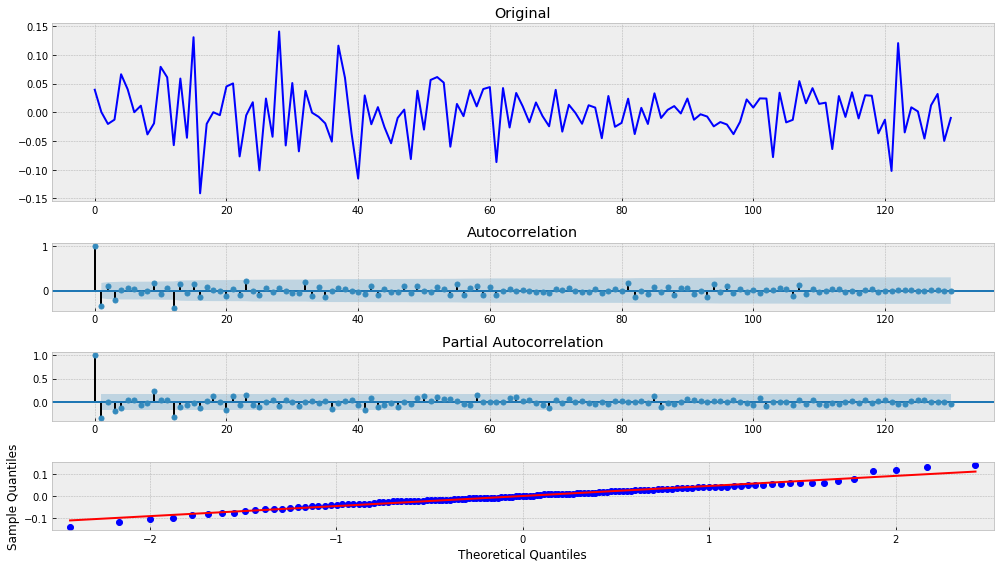

In [152]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


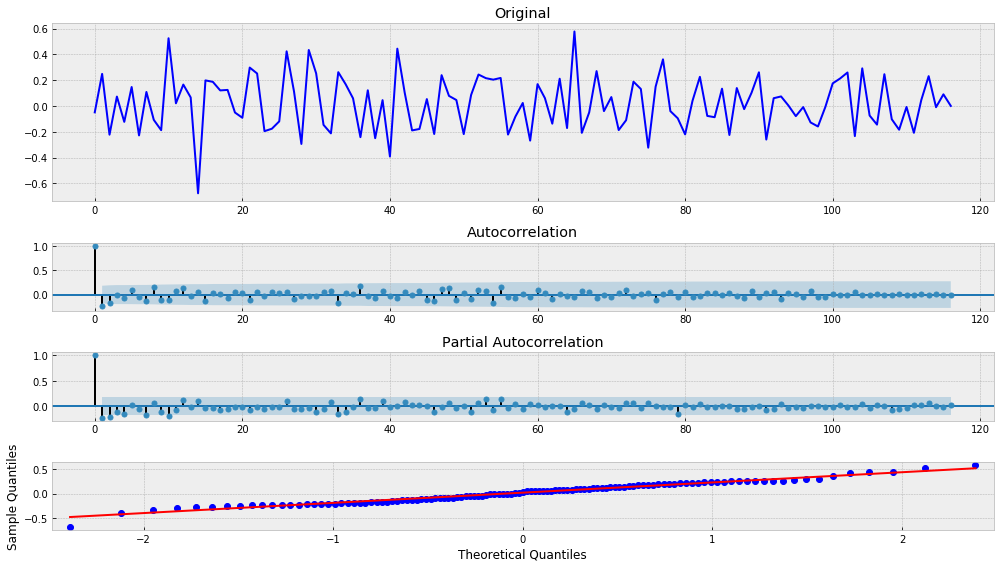

In [179]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [180]:
aic, order, mdl = _get_best_model(new_series)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInver

aic: -43.76706 | order: (4, 0, 2)


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Results of Dickey-Fuller Test:
Test Statistic                -1.124639e+01
p-value                        1.755310e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


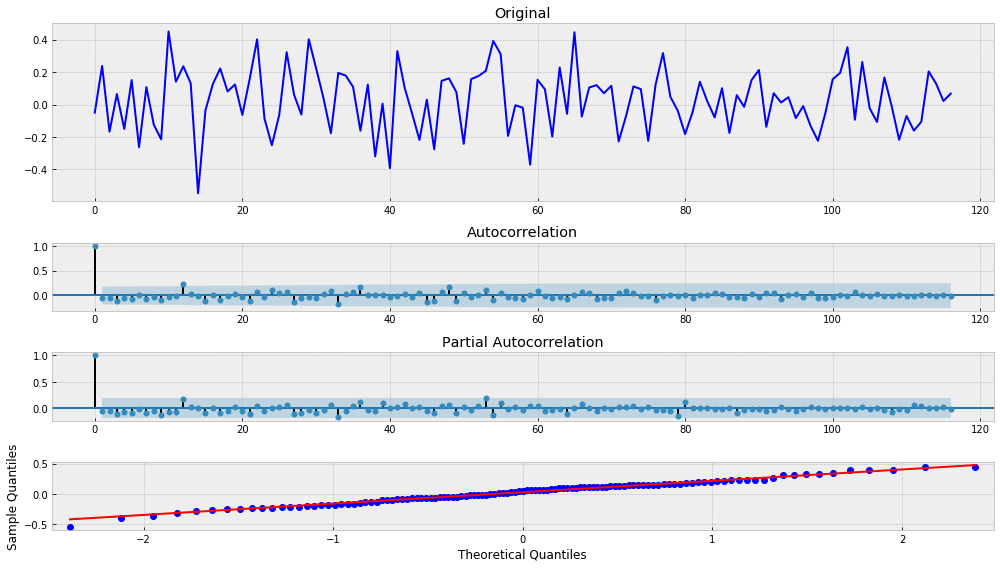

In [181]:
tsplot(mdl.resid)

In [186]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: -19.280781100582214
Iteration:     10,   Func. Count:    121,   Neg. LLF: -20.202345982144138
Iteration:     15,   Func. Count:    176,   Neg. LLF: -20.5993851543859
Iteration:     20,   Func. Count:    231,   Neg. LLF: -20.692478314673338
Iteration:     25,   Func. Count:    286,   Neg. LLF: -20.708258487161235
Iteration:     30,   Func. Count:    344,   Neg. LLF: -20.71094703874075
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.710993578641972
            Iterations: 34
            Function evaluations: 385
            Gradient evaluations: 33
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                20.7110
Distri

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


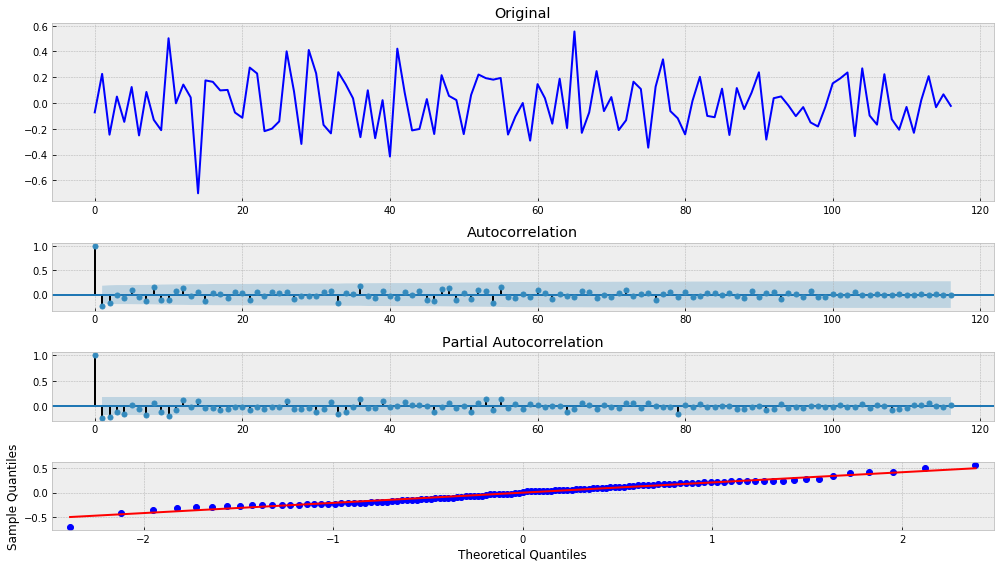

In [187]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [35]:
series = pd.read_csv("Series/international-airline-passengers.csv")

In [36]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

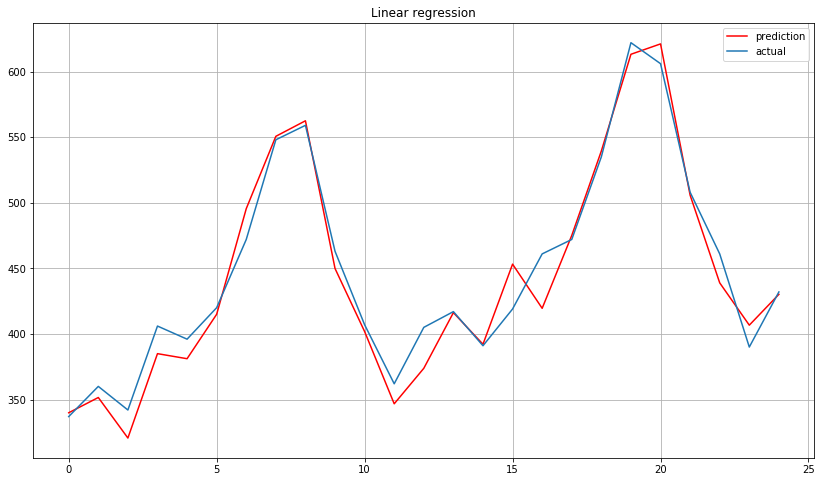

In [62]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016